# Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [148]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
import torch
import scipy
import datetime
from scipy.special import inv_boxcox

# File sorting

`*` matches 0 or more characters.

In [2]:
file_list = glob('/nvme0/gfas-frp/FRP_20??_??.nc')

A sample of file names.

In [5]:
file_list[:3]

['/nvme0/gfas-frp/FRP_2020_01.nc',
 '/nvme0/gfas-frp/FRP_2019_08.nc',
 '/nvme0/gfas-frp/FRP_2019_11.nc']

Sorting files by time to get deterministic order after loading.

In [3]:
files = sorted(file_list, key=lambda x: int(x[-8:-6])*100 + int(x[-5:-3]))

*Data is expected to be for 12 months*

In [10]:
len(files)

12

Saving the files in a separate location (once) to prevent unintended modification of original dataset. `shutil` allows efficient file operation by using shell commands under the hood.

In [20]:
# import shutil
# for file in files:
#     shutil.copy(file, '/nvme0/data_deepfwi/fwi-reanalysis')

# Preprocessing

Taking a look at data. `xarray` contains `open_dataset` function to lazy load the contents of the file.

In [12]:
xr.open_dataset(files[0])

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3600, time: 30)
Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.75 359.85 359.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2019-04-30
Data variables:
    frpfire    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-08 04:44:57 GMT by grib_to_netcdf-2.18.0: grib_to_n...

Each file contains the actual observation along with 9 day forecast.

Combining multiple files into single dataarray.

In [4]:
proc = xr.open_mfdataset(files)

/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Taking a look.

In [16]:
proc

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3600, time: 366)
Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.75 359.85 359.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2020-03-31
Data variables:
    frpfire    (time, latitude, longitude) float32 dask.array<chunksize=(30, 1800, 3600), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-08 04:44:57 GMT by grib_to_netcdf-2.18.0: grib_to_n...

**Pixel resolution**: *1800x3600*<br>
**Longitude resolution**: 0.10<br>
**Latitude resolution**: 0.10<br>

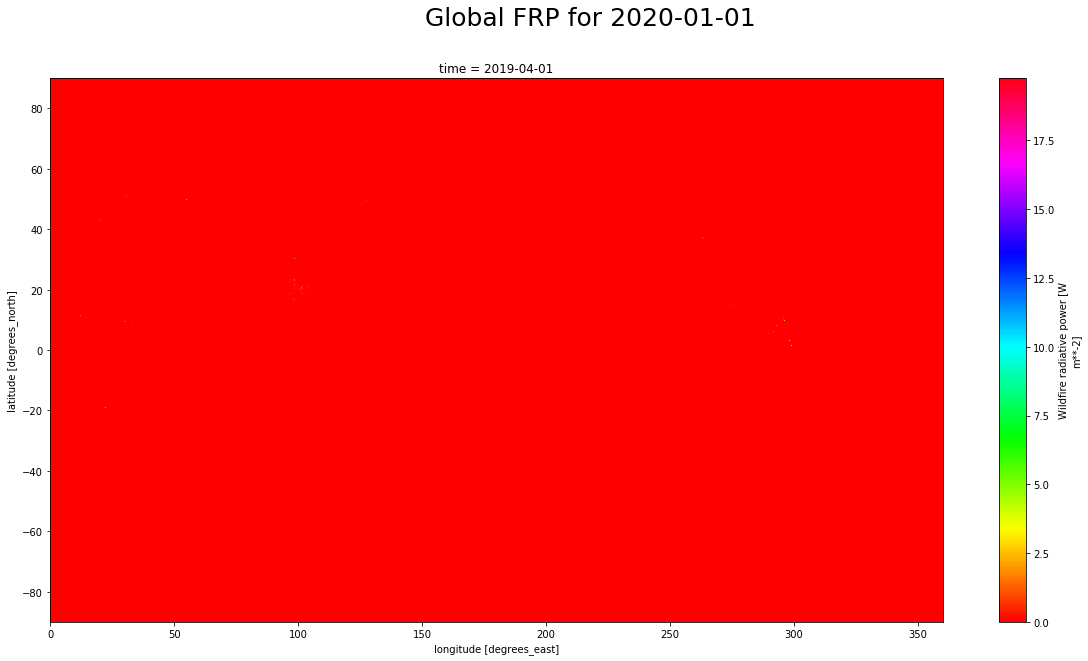

In [100]:
plt.figure(figsize = (20,10)).suptitle('Global FRP for 2020-01-01', fontsize=25)
proc.frpfire[0].plot(cmap='hsv')

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [19]:
np.isnan(proc.frpfire[0].values).any()

False

Printing general stats.

In [56]:
def stats(x):
    tmp = x.mean()
    print('mean', tmp)
    print('mad', abs(x-tmp).mean())
    print('var', x.var())
    print('min', x.min())
    print('max', x.max())

In [24]:
stats(proc.frpfire.values)

mean 0.00021382833
mad 0.0004302753
var 0.0012904834002256393
min -7.62939453125e-06
max 186.10562133789062


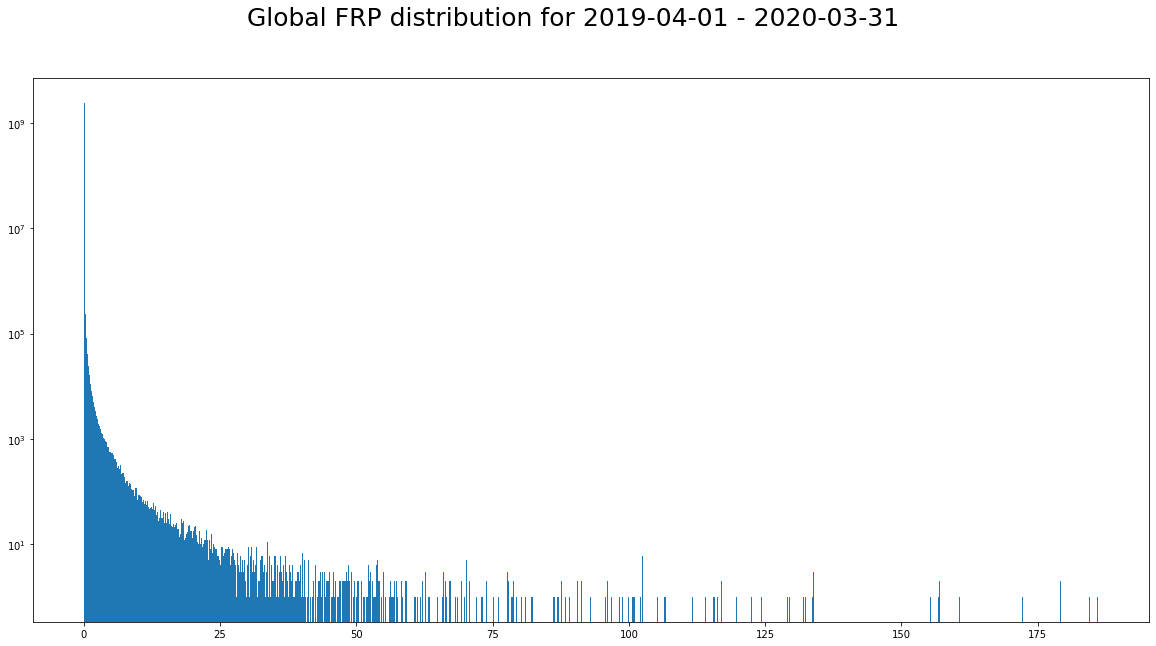

In [123]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(proc.frpfire.values.flatten(), bins=1000, cumulative=False, log=True);

### Applying the mask for water bodies

Obtaining high resolution mask from NaN mask of fwi-forecast.

In [190]:
mask_orig = ~np.isnan(xr.open_dataset('/nvme0/fwi-forecast/ECMWF_FWI_20190130_1200_hr_fwi.nc')['fwi'][0].values)

Resizing the mask to the resolution of gfas-frp

In [191]:
mask_resized = resize(mask_orig, proc.frpfire[0].values.shape) > 0.5

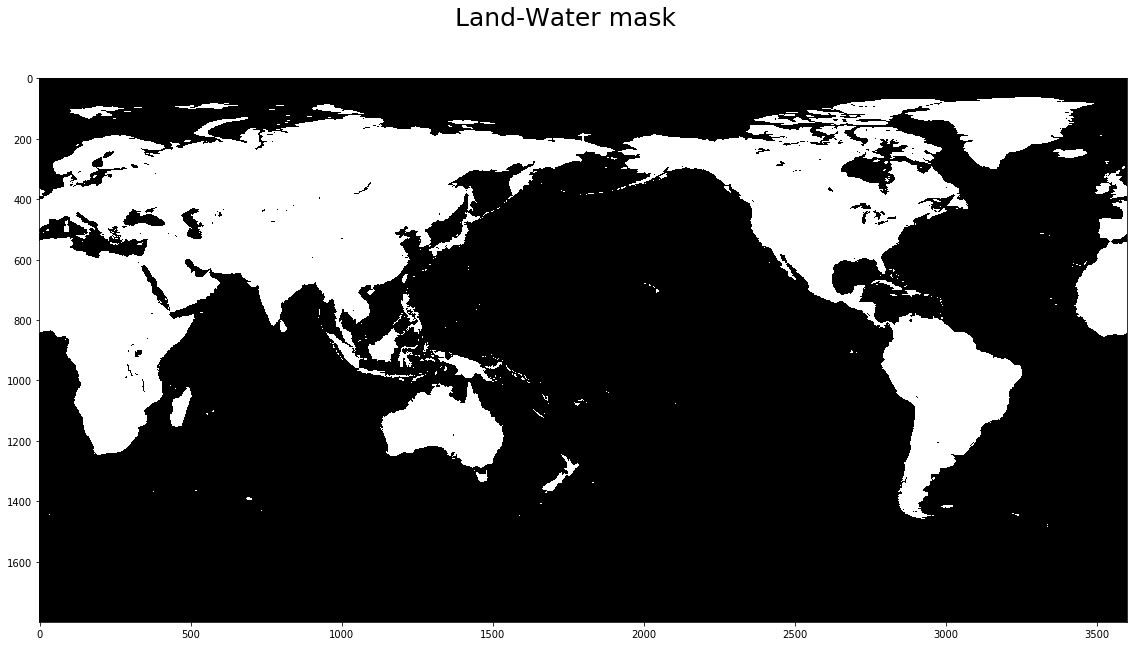

In [96]:
plt.figure(figsize = (20,10)).suptitle('Land-Water mask', fontsize=25)
plt.imshow(mask_resized, cmap='gray');

In [93]:
masked_sample = proc.frpfire[0].values.copy()
masked_sample[mask_resized] = 200

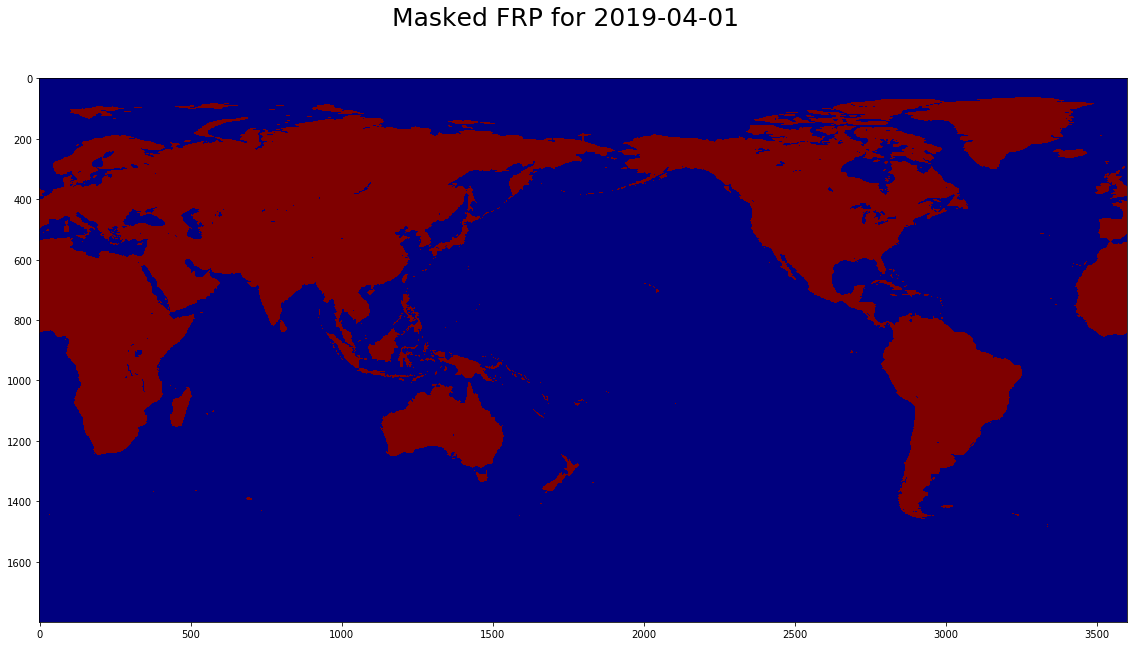

In [124]:
plt.figure(figsize = (20,10)).suptitle('Masked FRP for 2019-04-01', fontsize=25)
plt.imshow(mask_resized, cmap='jet');

In [192]:
np.save('mask_frp', mask_resized)

#### Stats for masked FRP

In [113]:
stats(proc.frpfire.values[np.broadcast_to(mask_resized, (366,)+mask_resized.shape)])

mean 0.0008449411
mad 0.0016858313
var 0.0051485044
min -7.6293945e-06
max 186.10562


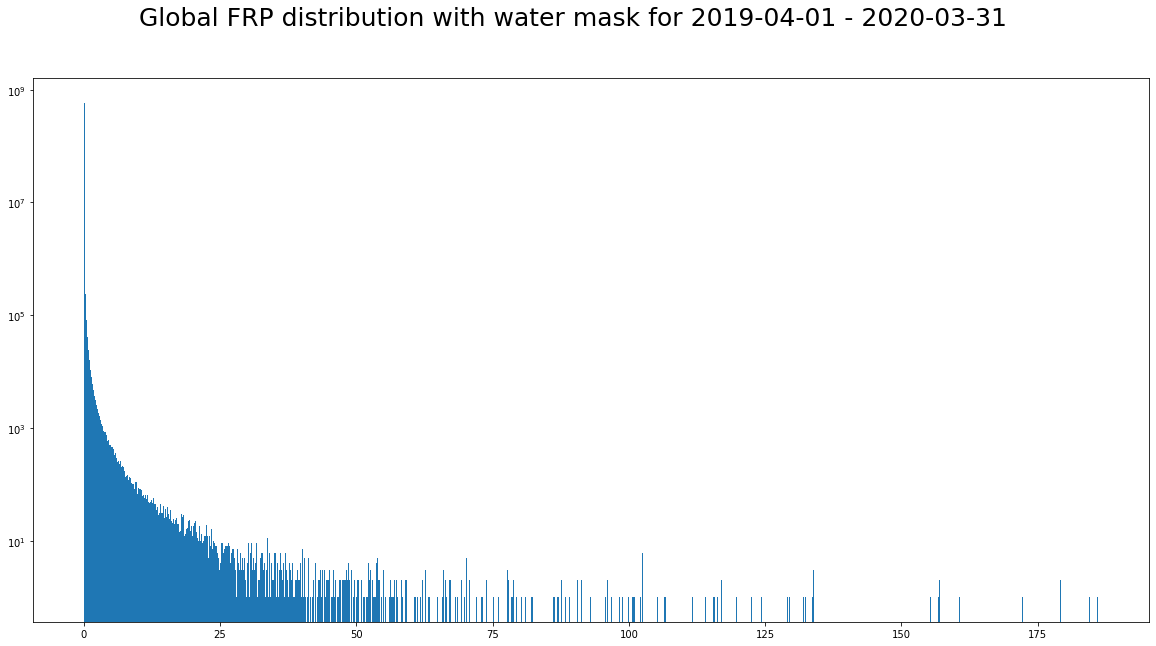

In [8]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution with water mask for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(proc.frpfire.values[np.broadcast_to(mask_resized, (366,)+mask_resized.shape)].flatten(), bins=1000, cumulative=False, log=True);

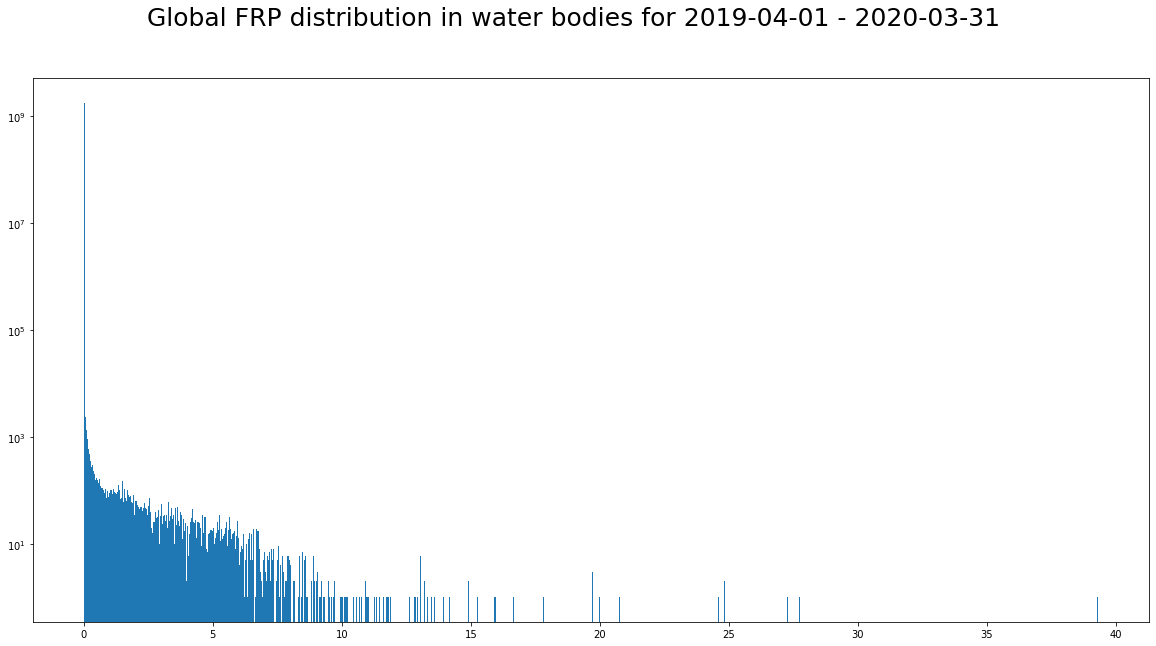

In [9]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution in water bodies for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(proc.frpfire.values[np.broadcast_to(~mask_resized, (366,)+mask_resized.shape)].flatten(), bins=1000, cumulative=False, log=True);

## Negative values in FRP

The negative values are unique and spread throughout the region and timescale.

In [110]:
np.unique(proc.frpfire.values[proc.frpfire.values<0])

array([-7.6293945e-06, -3.8146973e-06], dtype=float32)

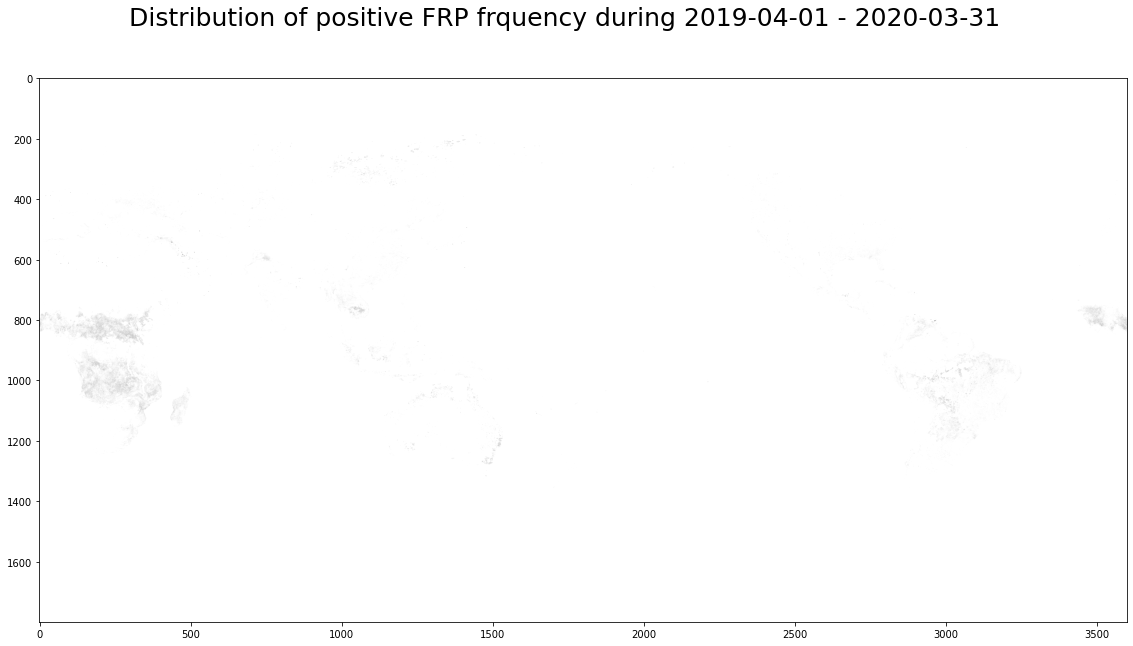

In [122]:
plt.figure(figsize = (20,10)).suptitle('Distribution of positive FRP frequency during 2019-04-01 - 2020-03-31', fontsize=25)
plt.imshow((proc.frpfire.values<0).mean(axis=0), cmap='gray')

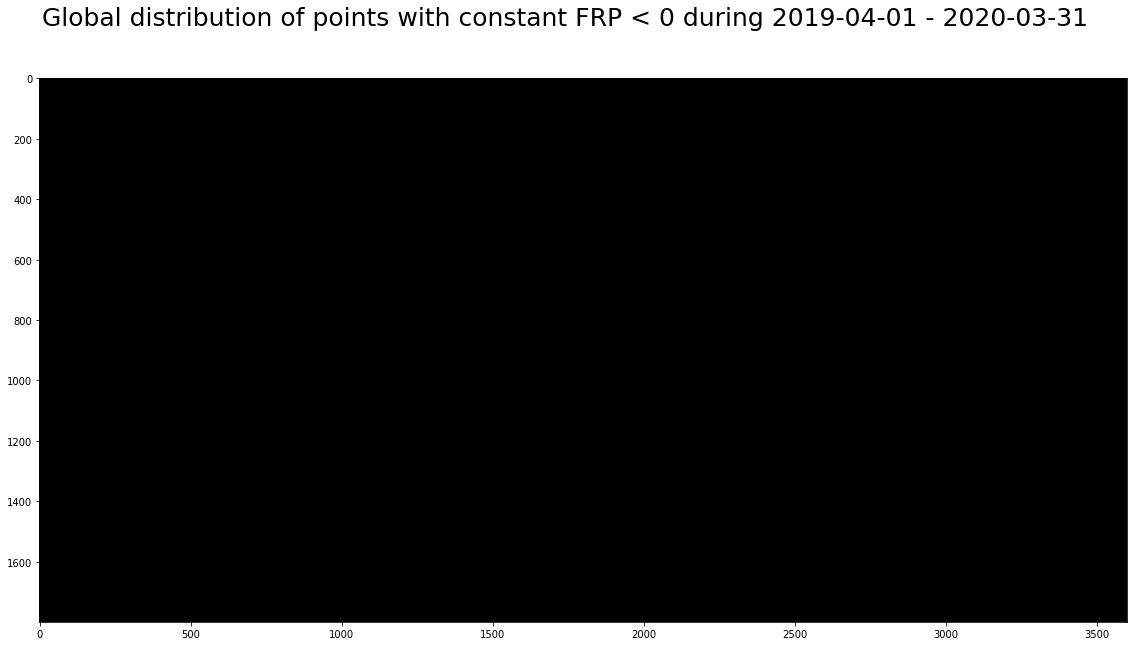

In [121]:
plt.figure(figsize = (20,10)).suptitle('Global distribution of points with constant FRP < 0 during 2019-04-01 - 2020-03-31', fontsize=25)
plt.imshow((proc.frpfire.values<0).sum(axis=0)<0, cmap='gray')

## Transformation

The transformation is done after the following pre-processing:
* Excluding water regions
* Clipping the (0, 0.5) FRP value range to 0.
* Excluding negative values

In [171]:
temp = proc.frpfire.values

In [172]:
temp[(temp>0)&(temp<0.5)] = 1e-10

Percent values falling in (0, 0.5) range

In [181]:
(np.broadcast_to(mask_resized, (366,)+mask_resized.shape)&(temp>0)).sum()/np.broadcast_to(mask_resized, (366,)+mask_resized.shape).size*100

0.006803194360116035

In [193]:
pre_transform = temp[np.broadcast_to(mask_resized, (366,)+mask_resized.shape)&(temp>0)]

In [201]:
stats(pre_transform)

mean 1.754791
mad 1.3919744
var 15.229703
min 0.50021935
max 186.10562


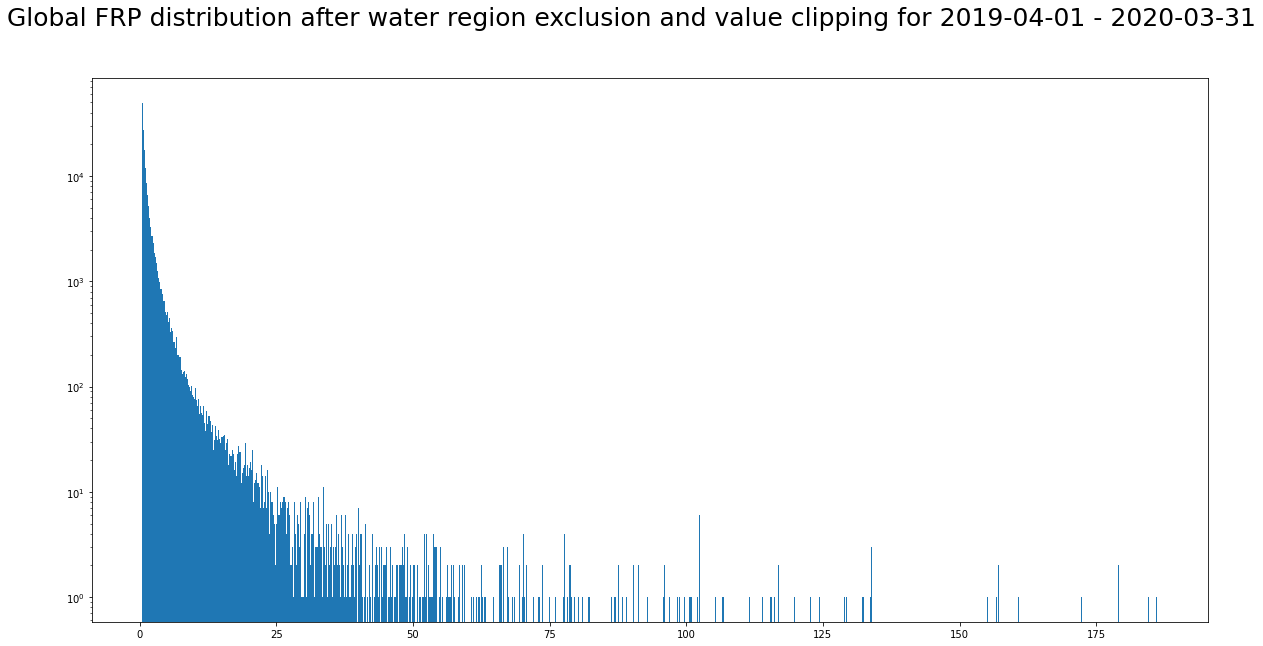

In [194]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution after water region exclusion and value clipping for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(pre_transform.flatten(), bins=1000, cumulative=False, log=True);

### Box-Cox transform

In [195]:
box_cox, lmbda = scipy.stats.boxcox(pre_transform)

In [196]:
lmbda

-0.8397658852658973

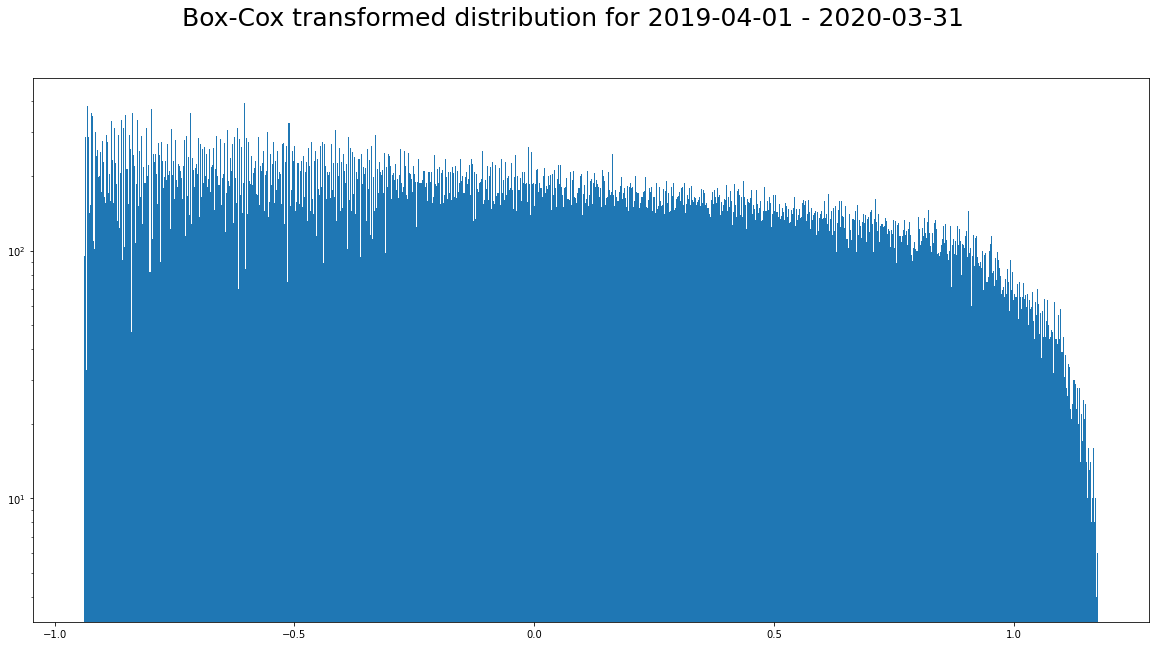

In [197]:
plt.figure(figsize = (20,10)).suptitle('Box-Cox transformed distribution for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(box_cox, bins=1000, cumulative=False, log=True);

In [187]:
stats(box_cox)

mean -0.06211442
mad 0.4730961
var 0.30641195
min -0.9396674
max 1.1760247


### Log transform

In [198]:
log = np.log(pre_transform)

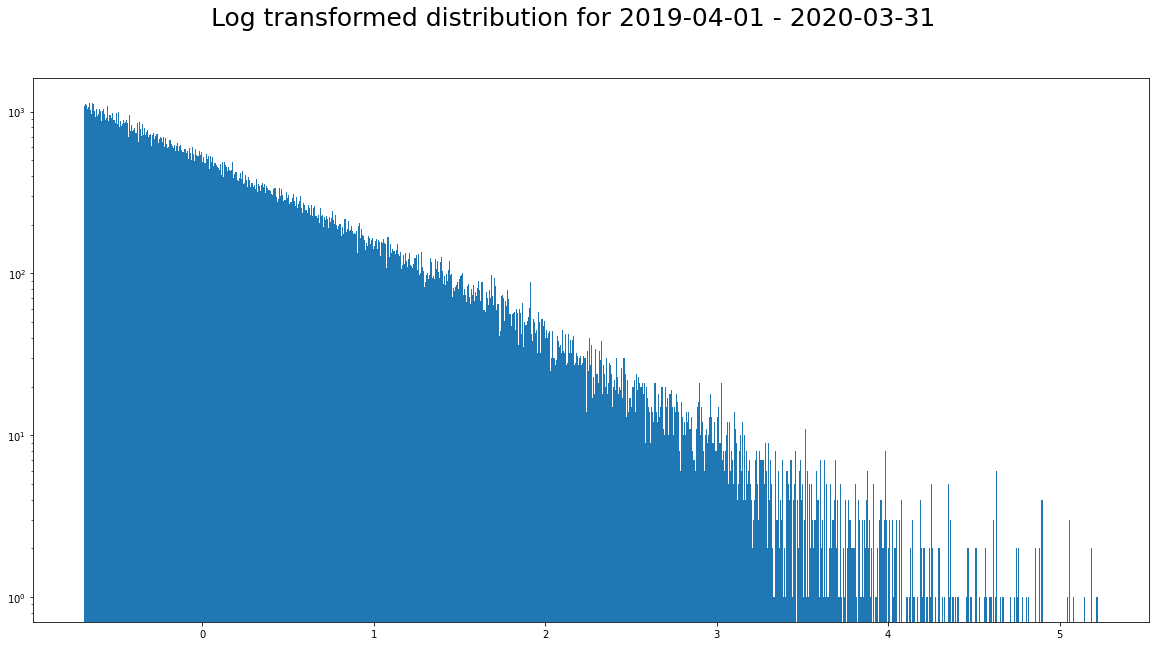

In [199]:
plt.figure(figsize = (20,10)).suptitle('Log transformed distribution for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(log, bins=1000, cumulative=False, log=True);

In [200]:
stats(log)

mean 0.1166933
mad 0.57324064
var 0.56349844
min -0.6927086
max 5.2263145


## Regions not prone to fire

In [136]:
frp_mean = proc.frpfire.values.mean(axis=0)

In [71]:
stats(frp_mean)

mean 0.00021382413
mad 0.0004112972
var 2.6930267e-05
min -1.5946686e-06
max 5.498016


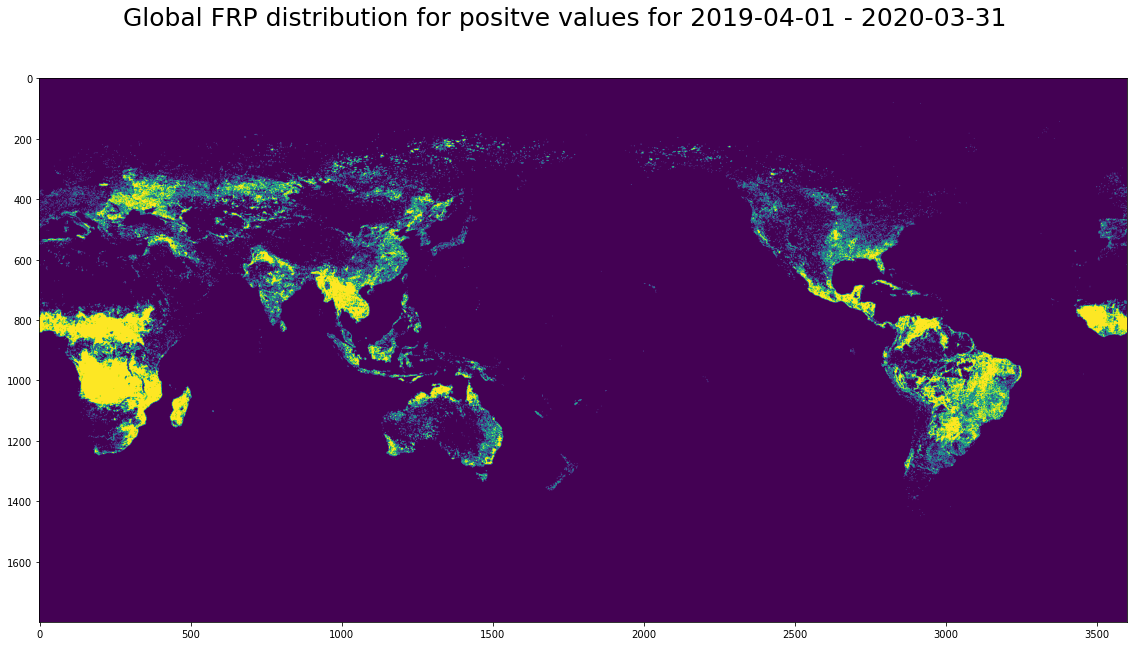

In [189]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution for positve values for 2019-04-01 - 2020-03-31', fontsize=25)
plt.imshow(frp_mean>0)

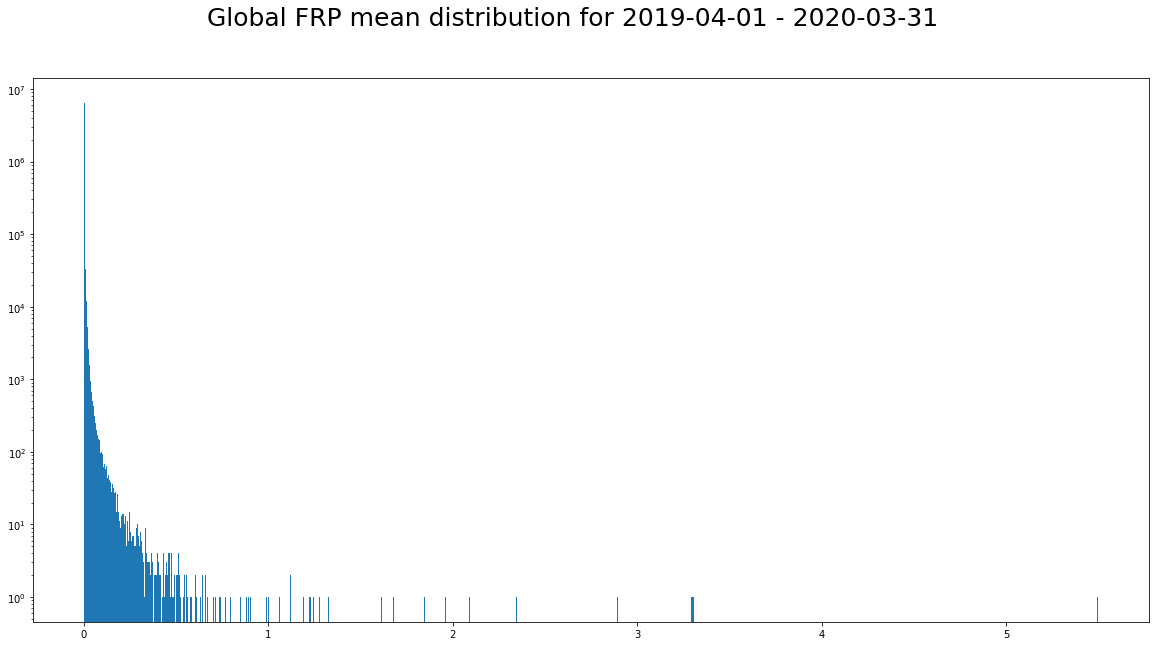

In [74]:
plt.figure(figsize = (20,10)).suptitle('Global FRP mean distribution for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(frp_mean.flatten(), bins=1000, cumulative=False, log=True);

In [95]:
stats(proc.frpfire.values[np.broadcast_to(frp_mean > 0, (366,)+(frp_mean > 0).shape)])

mean 0.0041893194
mad 0.008203738
var 0.025182659
min -7.6293945e-06
max 186.10562


### Box-Cox transform

Since there are negative values as well, we will use Yeo Johnson transform which is identical to Box-Cox for the positive values and is defined for negative values as well.

In [125]:
frp_0_tran, maxlog = scipy.stats.yeojohnson(proc.frpfire.values[np.broadcast_to(frp_mean > 0, (366,)+frp_mean.shape)])

In [132]:
frp_0_tran.max()

0.0027432828

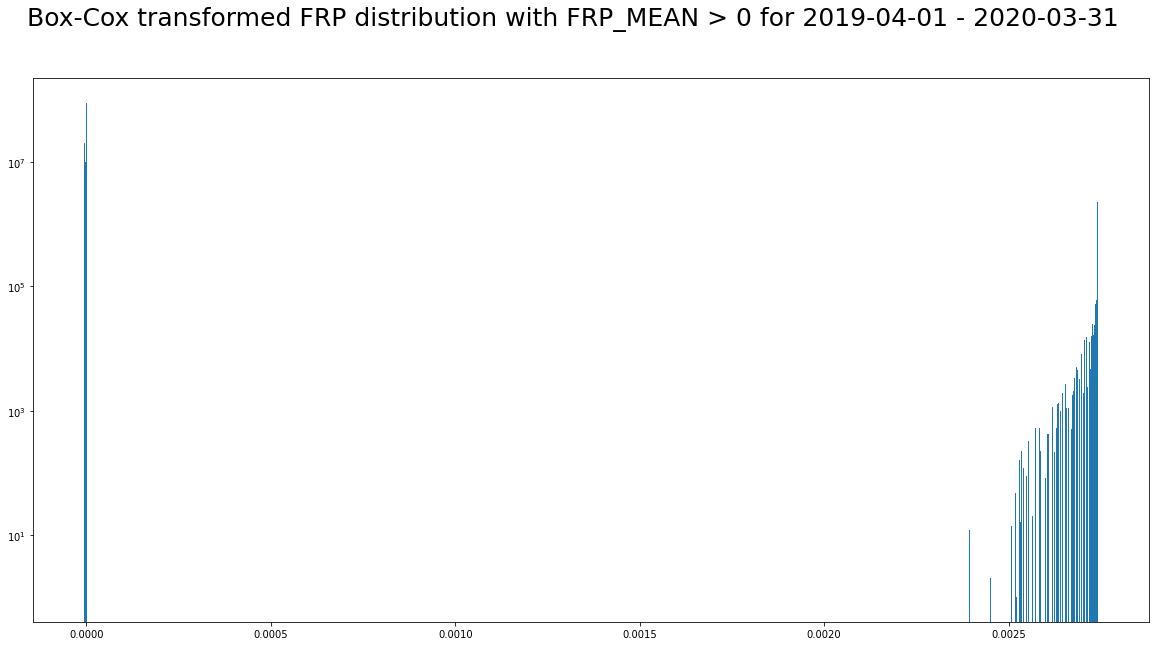

In [127]:
plt.figure(figsize = (20,10)).suptitle('Box-Cox transformed FRP distribution with FRP_MEAN > 0 for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(frp_0_tran, bins=1000, cumulative=False, log=True);

In [133]:
frp_0_tran2, maxlog2 = scipy.stats.yeojohnson(proc.frpfire.values[proc.frpfire.values>0])

In [140]:
maxlog2

-6.806687181055118

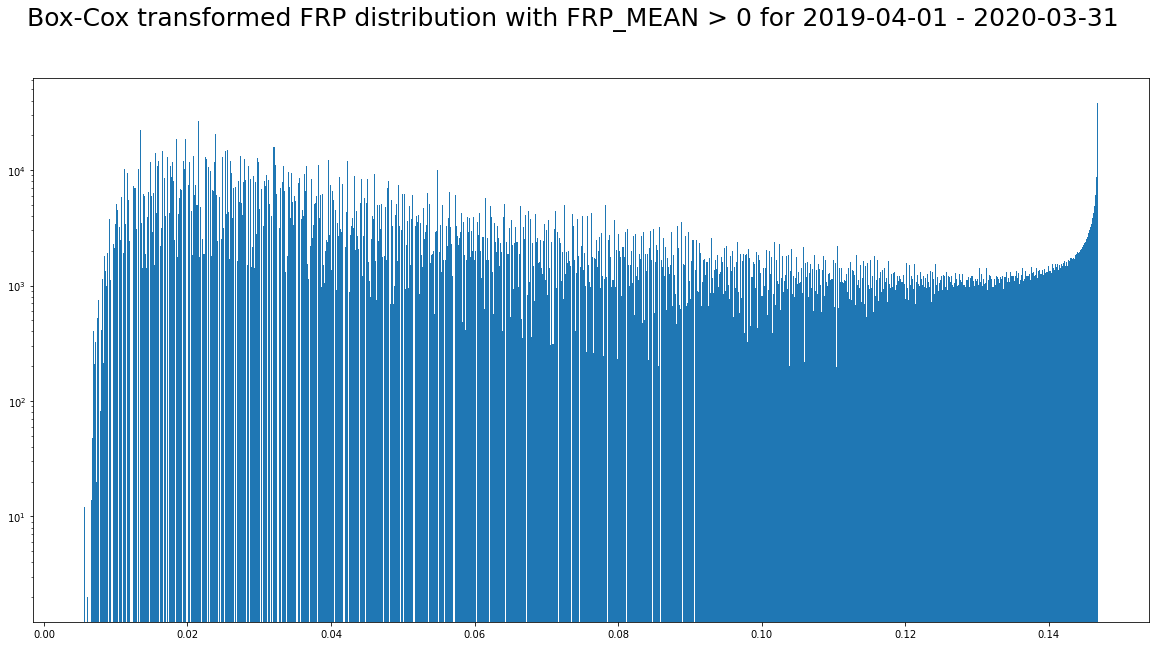

In [134]:
plt.figure(figsize = (20,10)).suptitle('Box-Cox transformed FRP distribution with FRP_MEAN > 0 for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(frp_0_tran2, bins=1000, cumulative=False, log=True);

In [ ]:
plt.imshow()